In [33]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [34]:
mean_gray = 0.1307
stddev_gray = 0.3081

#input[channel] = (input[chanel]-mean[chanel])/std[chanel]

transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,),(stddev_gray))])

train_dataset = datasets.MNIST(root='./data',train = True,transform = transforms,download = True)
test_dataset = datasets.MNIST(root='./data',train = False,transform = transforms)


In [35]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=0.3081)
           )

In [36]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=0.3081)
           )

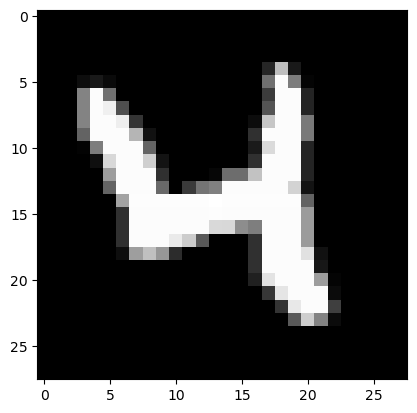

In [37]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy()*stddev_gray+mean_gray
plt.imshow(random_img.reshape(28,28),cmap = 'gray')

In [38]:
train_dataset[20][1]

4

In [39]:
#data loader
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)
test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False)




In [40]:
len(train_load)

600

In [41]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #same padding = filter-1/2
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1,padding = 1)
        #output_size of each of 8 feature maps = inputsize-filersize+2*padding/stride  +1 = 28
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        #output size = 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels = 8,out_channels = 32, kernel_size = 5,stride = 1, padding = 2)
        #output size of each feature (14-5+4)+1 = 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        #flatten 32 feature map: 7*7*32 = 1568
        self.fc1 = nn.Linear(1568,600)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(600,10)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        # flatten the feature maps to feed to fc1(100,1568)
        out = out.view(-1,1568)
        
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
    
        

In [42]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)



In [43]:
#mvement around
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate (train_load):
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("input_shape:",inputs.shape)
    print("labels_shape",labels.shape)
    output = model(inputs)
    print("output_shape",output.shape)
    _,predicted = torch.max(output,1)
    print("predicted_shape",predicted.shape)
    break

input_shape: torch.Size([100, 1, 28, 28])
labels_shape torch.Size([100])
output_shape torch.Size([100, 10])
predicted_shape torch.Size([100])


In [44]:
# training
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i,(inputs,labels) in enumerate(train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        
        loss = loss_fn(outputs,labels)
        
        iter_loss+=loss.item() #item to extract the value from tensor
        
        optimizer.zero_grad()  #w<--w-lr*grad
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs,1)
        
        correct+=(predicted==labels).sum().item()
        
        iterations+=1
        
    
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100*correct/len(train_dataset))
    
    #test phase
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    
    for i,(inputs,labels) in enumerate(test_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        
        loss = loss_fn(outputs,labels)
        
        testing_loss+=loss.item() #item to extract the value from tensor
        
        
        _,predicted = torch.max(outputs,1)
        
        correct+=(predicted==labels).sum().item()
        
        iterations+=1
    
    
    test_loss.append(testing_loss/iterations)
    test_accuracy.append(100*correct/len(test_dataset))
    
    
    print("epoch{}/{}, training loss {:.3f}, training accuracy {:.3f}, testing loss {:.3f}, testing accuracy {:.3f}".format(
    epoch+1,num_epochs,train_loss[-1],train_accuracy[-1],test_loss[-1],test_accuracy[-1]))
        
        
        
        
        

epoch1/10, training loss 0.471, training accuracy 87.967, testing loss 0.057, testing accuracy 98.250
epoch2/10, training loss 0.125, training accuracy 96.303, testing loss 0.044, testing accuracy 98.600
epoch3/10, training loss 0.090, training accuracy 97.428, testing loss 0.045, testing accuracy 98.740
epoch4/10, training loss 0.079, training accuracy 97.753, testing loss 0.038, testing accuracy 98.930
epoch5/10, training loss 0.070, training accuracy 97.978, testing loss 0.041, testing accuracy 98.740
epoch6/10, training loss 0.063, training accuracy 98.180, testing loss 0.033, testing accuracy 98.950
epoch7/10, training loss 0.063, training accuracy 98.175, testing loss 0.037, testing accuracy 98.860
epoch8/10, training loss 0.056, training accuracy 98.383, testing loss 0.040, testing accuracy 98.940
epoch9/10, training loss 0.056, training accuracy 98.472, testing loss 0.033, testing accuracy 99.000
epoch10/10, training loss 0.055, training accuracy 98.430, testing loss 0.036, tes

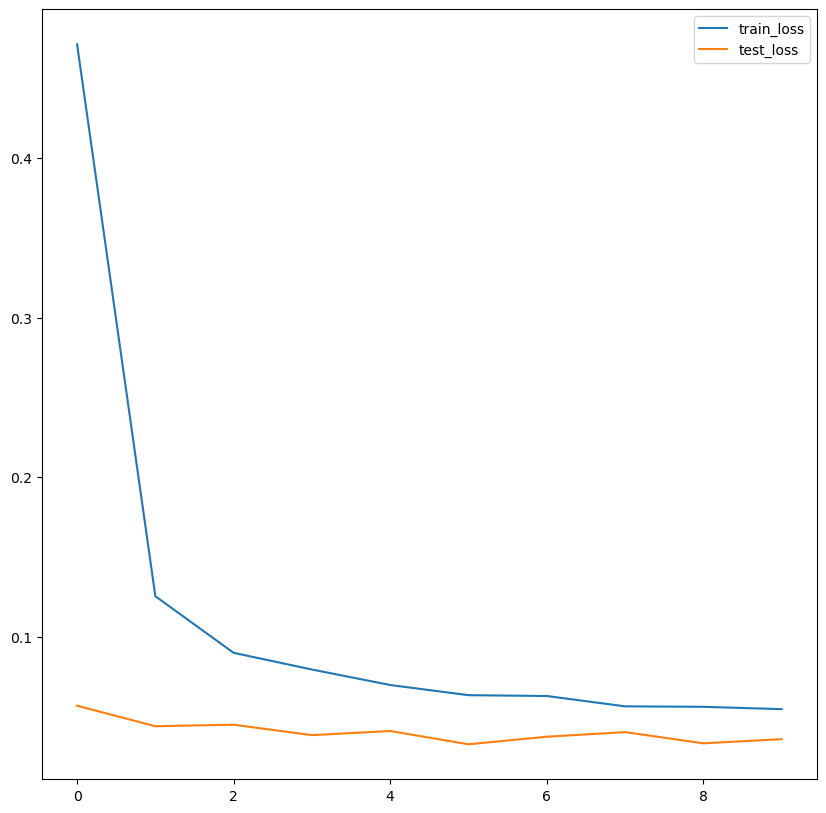

In [45]:
#plot
f = plt.figure(figsize = (10,10))
plt.plot(train_loss,label = "train_loss")
plt.plot(test_loss, label = "test_loss")
plt.legend()
plt.show()

In [46]:
#making predictions

import torch
torch.save(model.state_dict(),"model.pth")
